In [1]:
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import utils
import itertools
import theano
from theano import tensor as tt

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', fontsize=20)
pl.rc('lines', linewidth=4)

def fisher(t, tparams, gpparams, a=[1]):
    a = np.array(a)
    log_s, log_w0, log_q, diag = gpparams
    kernel = xo.gp.terms.SHOTerm(log_S0=log_s, log_w0=log_w0, log_Q=log_q)
    Q = a[:, None]*a[None, :]
    gp = xo.gp.GP(kernel=kernel, diag=diag*np.ones_like(t), x=t, J=2*len(a), Q=Q)
    dtrans = utils.transit(t, *tparams)
    x = tt.dmatrix()
    y = tt.dmatrix()
    f = theano.function([x, y], [x.T.dot(gp.apply_inverse_vector(y))])
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        x = np.tile(x, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(x)).T
        y = np.tile(y, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(y)).T
        fish[i, j] = f(x, y)[0][0, 0]
    return np.sqrt(np.diag(np.linalg.inv(fish)))

def fisher_white_noise_only(t, tparams, diag):
    dtrans = utils.transit(t, *tparams)
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        fish[i, j] = (1/diag)*x.T.dot(y)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

t = np.linspace(-5, 5, 3000)
tparams = [0.0, 0.1, 1.0, 0.2]  # t0, r, d, tin

alpha = -13 # total variance 
x = np.linspace(-3, 3, 50)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)
a = [1, 2]

w0T = 0.1
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

oneband = [fisher(t, tparams, [ls + 2*np.log(np.mean(a)), logw0, logq, d]) for ls, d in zip(logs0, diag)]
oneband = np.array(oneband).T
np.savetxt('data/fisher_oneband_{0}.txt'.format(w0T), oneband)

twoband = [fisher(t, tparams, [ls, logw0, logq, 2*d], a=a) for ls, d, in zip(logs0, diag)]
twoband = np.array(twoband).T
np.savetxt('data/fisher_twoband_{0}.txt'.format(w0T), twoband)

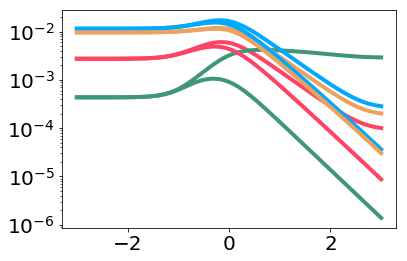

In [13]:
oneband = np.loadtxt('data/fisher_oneband_{0}.txt'.format(10))
twoband = np.loadtxt('data/fisher_twoband_{0}.txt'.format(10))

pl.semilogy(x, oneband[0], color=red)
pl.semilogy(x, oneband[1], color=green)
pl.semilogy(x, oneband[2], color=blue)
pl.semilogy(x, oneband[3], color=yellow)

pl.semilogy(x, twoband[0], color=red)
pl.semilogy(x, twoband[1], color=green)
pl.semilogy(x, twoband[2], color=blue)
pl.semilogy(x, twoband[3], color=yellow)

In [41]:
t = np.linspace(-5, 5, 3000)
tparams = [0.0, 0.1, 1.0, 0.2]  # t0, r, d, tin

alpha = -13 # total variance 
x = np.linspace(-3, 3, 50)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)
a = [1, 2]

oneband1 = [fisher_white_noise_only(t, tparams, d) for d in diag]
oneband1 = np.array(oneband1).T
np.savetxt('data/fisher_white_noise_only_1.txt', oneband1)

oneband5 = [fisher_white_noise_only(t, tparams, 10*d) for d in diag]
oneband5 = np.array(oneband5).T
np.savetxt('data/fisher_white_noise_only_root5.txt', oneband5)

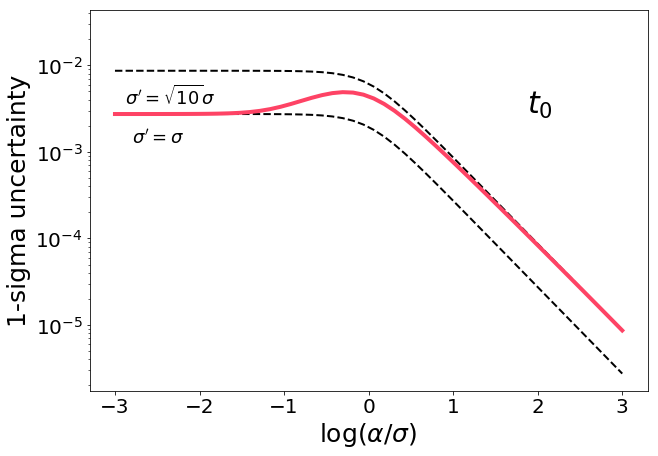

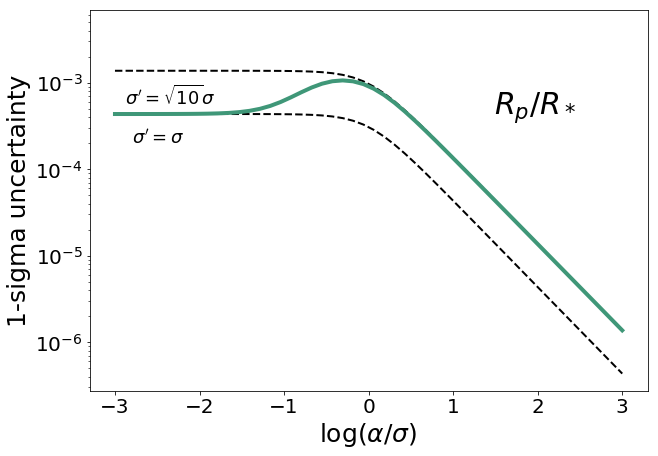

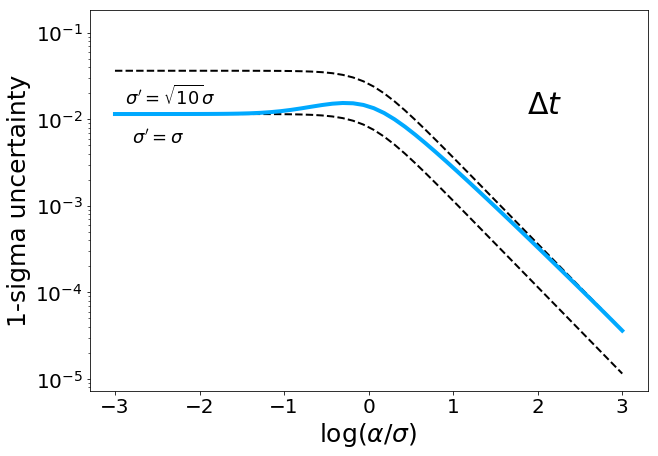

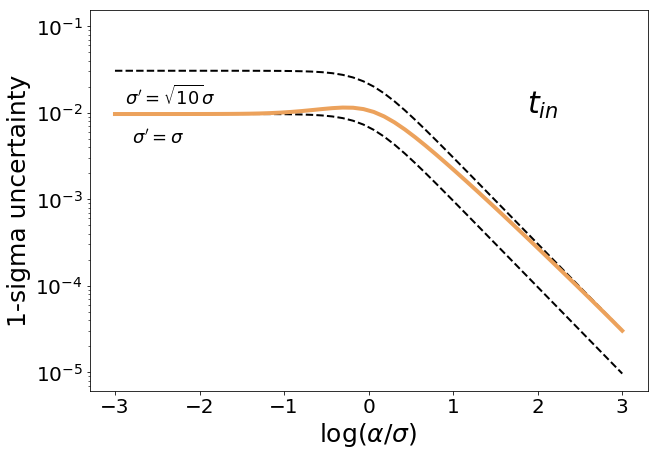

In [100]:
twoband = np.loadtxt('data/fisher_twoband_{0}.txt'.format(10))

pl.figure(figsize=(10, 7))
pl.semilogy(x, oneband1[0], '--', color='k', linewidth=2)
pl.semilogy(x, oneband5[0], '--', color='k', linewidth=2)
pl.semilogy(x, twoband[0], color=red)
pl.annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$t_0$", xy=(0.8, 0.75), xycoords='figure fraction', fontsize=30)
pl.xlabel(r"$\log(\alpha/\sigma)$")
pl.ylabel("1-sigma uncertainty")
pl.ylim(oneband5[0, -1]/5, oneband5[0, 0]*5)
pl.savefig('plots/fisher_t0.pdf')

pl.figure(figsize=(10, 7))
pl.semilogy(x, oneband1[1], '--', color='k', linewidth=2)
pl.semilogy(x, oneband5[1], '--', color='k', linewidth=2)
pl.semilogy(x, twoband[1], color=green)
pl.annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$R_p/R_*$", xy=(0.75, 0.75), xycoords='figure fraction', fontsize=30)
pl.xlabel(r"$\log(\alpha/\sigma)$")
pl.ylabel("1-sigma uncertainty")
pl.ylim(oneband5[1, -1]/5, oneband5[1, 0]*5)
pl.savefig('plots/fisher_rp.pdf')

pl.figure(figsize=(10, 7))
pl.semilogy(x, oneband1[2], '--', color='k', linewidth=2)
pl.semilogy(x, oneband5[2], '--', color='k', linewidth=2)
pl.semilogy(x, twoband[2], color=blue)
pl.annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$\Delta t$", xy=(0.8, 0.75), xycoords='figure fraction', fontsize=30)
pl.xlabel(r"$\log(\alpha/\sigma)$")
pl.ylabel("1-sigma uncertainty")
pl.ylim(oneband5[2, -1]/5, oneband5[2, 0]*5)
pl.savefig('plots/fisher_dt.pdf')

pl.figure(figsize=(10, 7))
pl.semilogy(x, oneband1[3], '--', color='k', linewidth=2)
pl.semilogy(x, oneband5[3], '--', color='k', linewidth=2)
pl.semilogy(x, twoband[3], color=yellow)
pl.annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='figure fraction', fontsize=18)
pl.annotate(r"$t_{in}$", xy=(0.8, 0.75), xycoords='figure fraction', fontsize=30)
pl.xlabel(r"$\log(\alpha/\sigma)$")
pl.ylabel("1-sigma uncertainty")
pl.ylim(oneband5[3, -1]/5, oneband5[3, 0]*5)
pl.savefig('plots/fisher_tin.pdf')

In [2]:
q = 5, 2, 1/np.sqrt(2), 0.3, 0.1
kernel = [xo.gp.terms.SHOTerm(log_S0=-5, log_w0=0, log_Q=lq) for lq in np.log(q)]
f = np.logspace(-3, 1, 1000)
omega = 2*np.pi*f
psd = np.array([k.psd(omega).eval() + 0.001*np.ones_like(omega) for k in kernel])
psd /= 2*np.pi

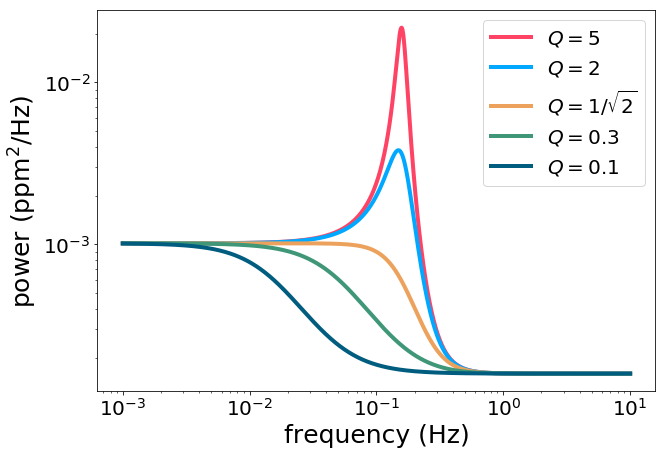

In [24]:
pl.figure(figsize=(10, 7))
colors = [red, blue, yellow, green, darkblue]
labels = r"$Q = 5$", r"$Q = 2$", r"$Q = 1/\sqrt{2}$", r"$Q=0.3$", r"$Q=0.1$" 
[pl.loglog(f, p, color=colors[i], label=labels[i]) for i, p in enumerate(psd)]
pl.legend()
pl.xlabel("frequency (Hz)")
pl.ylabel(r"power (ppm$^2$/Hz)")
pl.savefig("plots/sho_psd.pdf")

In [36]:
t = np.linspace(0, 100, 1000)
n = np.random.randn(len(t), 1)
gp = [xo.gp.GP(kernel=k, J=2, diag=0.001*np.ones_like(t), x=t) for k in kernel]
y = [gp.dot_l(n).eval() for gp in gp]

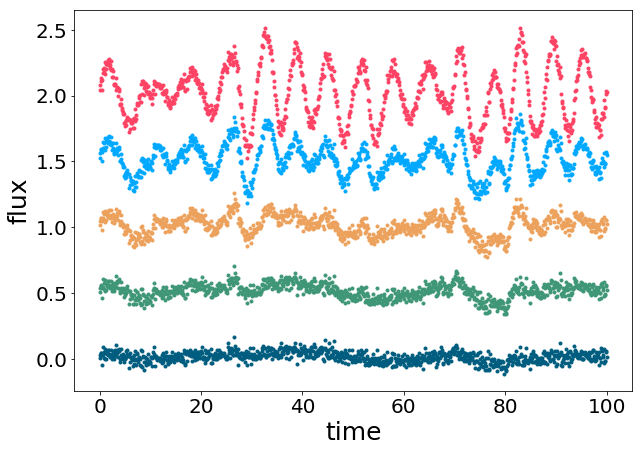

In [39]:
pl.figure(figsize=(10, 7))
colors = [red, blue, yellow, green, darkblue]
labels = r"$Q = 5$", r"$Q = 2$", r"$Q = 1/\sqrt{2}$", r"$Q=0.3$", r"$Q=0.1$" 
[pl.plot(t, flux + 0.5*i, '.', color=colors[::-1][i], label=labels[i]) for i, flux in enumerate(y[::-1])]
#pl.legend()
pl.xlabel("time")
pl.ylabel("flux")
pl.savefig("plots/samples.pdf")

In [50]:
Q = np.array([1, 2])
Q = Q[None, :]*Q[:, None]
gp = xo.gp.GP(kernel=kernel[2], J=4, diag=0.001*np.ones((2, len(t))), x=t, Q=Q)

In [68]:
y = gp.dot_l(np.random.randn(2*len(t), 1)).eval()
b1, b2 = y[1::2], y[::2]

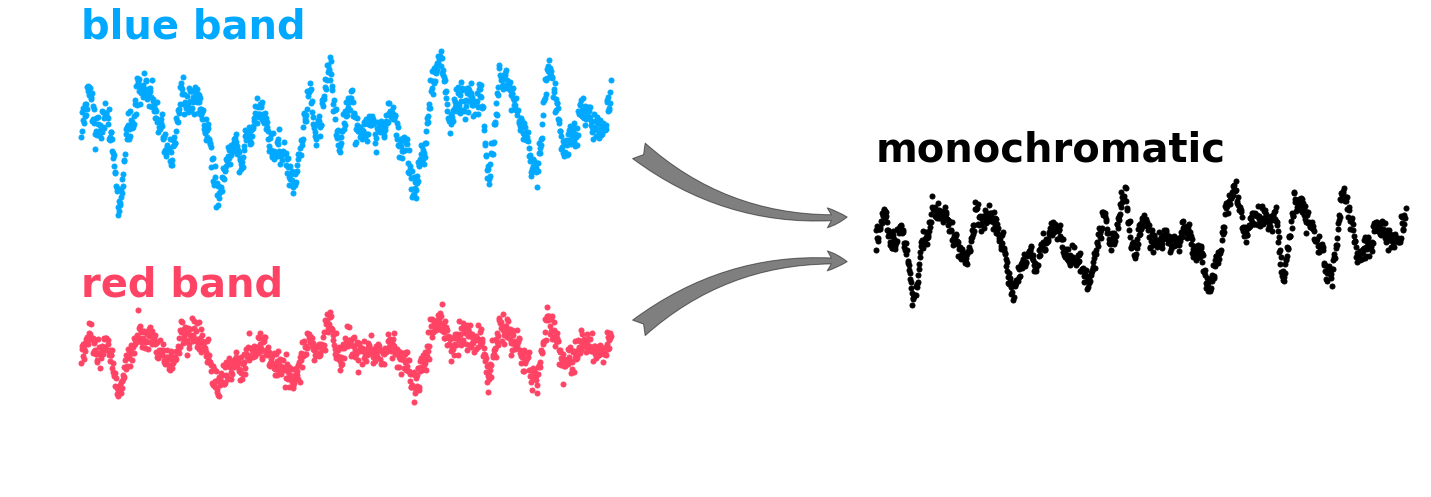

In [205]:
import matplotlib.patches as mpatches

fig = pl.figure(figsize=(20, 7))
pl.plot(t, b1+0.5, '.', color=blue, markersize=10)
pl.plot(t, b2-0.5, '.', color=red, markersize=10)
pl.plot(t + 150, (b1+b2)/2, 'k.', markersize=10)
pl.gca().annotate("", xy=(145, -0.1), xytext=(105, -0.4), 
            arrowprops=dict(arrowstyle="fancy",
                            color="k",
                            alpha=0.5,
                            shrinkB=2,
                            connectionstyle="arc3,rad=-0.2",
                            mutation_scale=50))

pl.gca().annotate("", xy=(145, 0.1), xytext=(105, 0.4), 
            arrowprops=dict(arrowstyle="fancy",
                            color="k",
                            alpha=0.5,
                            shrinkB=2,
                            connectionstyle="arc3,rad=0.2",
                            mutation_scale=50)
                 )

pl.gca().annotate("blue band", xy=(0, 0.9), fontsize=40, color=blue, weight='bold')
pl.gca().annotate("red band", xy=(0, -0.25), fontsize=40, color=red, weight='bold')
pl.gca().annotate("monochromatic", xy=(150, 0.35), fontsize=40, color='k', weight='bold')

pl.ylim(-1, 1)
pl.xlim(-1, 251)

fig.tight_layout()
fig.patch.set_visible('False')
fig.gca().axis('off')

pl.savefig('plots/schematic.pdf', bbox_inches='tight')

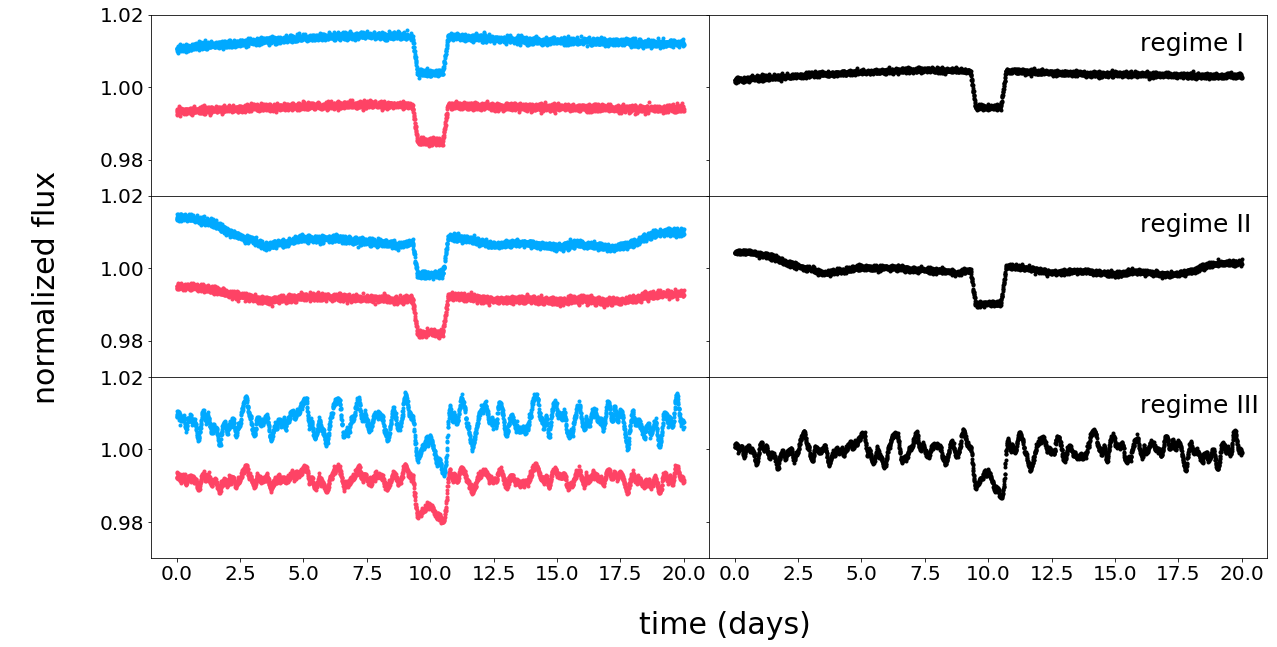

In [306]:
import mcmc

fig, ax = pl.subplots(3, 2, figsize=(20, 10), sharex=True, sharey=True)
pl.subplots_adjust(hspace=0, wspace=0)


t = np.linspace(0, 20, 3000)
tparams = [10.0, 0.1, 1.0, 0.2]  # t0, r, d, tin

alpha = -13 # total variance 
x = np.linspace(-3, 3, 20)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)
a = [1, 2]

w0T = 0.1
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

logs0 = logs0[11]
diag = diag[11]
logsig = logsig[11]

y2d, y1d = mcmc.make_data(t, logs0 + 2*np.log(np.mean(a)), logw0, 
                              logq, logsig, 
                              tparams[0], tparams[1], 
                              tparams[2], tparams[3], a[1])

#fig = pl.figure(figsize=(10, 7))
ax[0, 0].plot(t, y2d[::2]-0.008, '.', color=red)
ax[0, 0].plot(t, y2d[1::2]+0.008, '.', color=blue)
ax[0, 1].plot(t, y1d, '.', color='k')
ax[0, 1].annotate("regime I", xy=(16, 1.01), fontsize=25)
#pl.savefig('plots/regime1.pdf')

x = np.linspace(-3, 3, 20)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)

w0T = 0.5
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

logs0 = logs0[11]
diag = diag[11]
logsig = logsig[11]

y2d, y1d = mcmc.make_data(t, logs0 + 2*np.log(np.mean(a)), logw0, 
                              logq, logsig, 
                              tparams[0], tparams[1], 
                              tparams[2], tparams[3], a[1])

#fig = pl.figure(figsize=(10, 7))
ax[1, 0].plot(t, y2d[::2]-0.008, '.', color=red)
ax[1, 0].plot(t, y2d[1::2]+0.008, '.', color=blue)
ax[1, 1].plot(t, y1d, '.', color='k')
ax[1, 1].annotate("regime II", xy=(16, 1.01), fontsize=25)
#pl.savefig('plots/regime2.pdf')

x = np.linspace(-3, 3, 20)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)

w0T = 10.0
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

logs0 = logs0[11]
diag = diag[11]
logsig = logsig[11]

y2d, y1d = mcmc.make_data(t, logs0 + 2*np.log(np.mean(a)), logw0, 
                              logq, logsig, 
                              tparams[0], tparams[1], 
                              tparams[2], tparams[3], a[1])

#fig = pl.figure(figsize=(10, 7))
ax[2, 0].plot(t, y2d[::2]-0.008, '.', color=red)
ax[2, 0].plot(t, y2d[1::2]+0.008, '.', color=blue)
ax[2, 1].plot(t, y1d, '.', color='k')
ax[2, 1].annotate("regime III", xy=(16, 1.01), fontsize=25)

[ax.set_ylim(0.97, 1.02) for ax in np.array(ax).flatten()]
ax[2, 1].annotate("normalized flux", xy=(0.025, 0.7), xycoords='figure fraction', rotation=90, fontsize=30)
ax[2, 1].annotate("time (days)", xy=(0.5, 0.02), xycoords='figure fraction', fontsize=30)
pl.savefig('plots/regimes.pdf')